# Notebook for the project on Federated Learning - Brain Tunors MRI Dataset

In [2]:
# Setting up (imports, seeds, paths, etc)

from pathlib import Path
import os, random
from collections import Counter, defaultdict
import numpy as np

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# This notebook sits in: KI_PROJECT / Jupyter-notebooks
# Data sits in:         KI_PROJECT / data / {Training, Testing}
# So DATA_ROOT is one level up from the notebook, inside 'data'
PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name == "Jupyter-notebooks") else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data"

TRAIN_DIR = DATA_ROOT / "Training"
TEST_DIR  = DATA_ROOT / "Testing"

# Canonical class order (keep this constant everywhere)
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]
LABEL_MAP   = {c: i for i, c in enumerate(CLASS_NAMES)}

# Supported image extensions
IMG_EXTS = {".jpg", ".jpeg", ".png"}

def is_image_file(p: Path) -> bool:
    return p.is_file() and (p.suffix.lower() in IMG_EXTS)

print("PROJECT_ROOT:", PROJECT_ROOT.resolve())
print("DATA_ROOT   :", DATA_ROOT.resolve())
print("TRAIN_DIR   :", TRAIN_DIR.resolve())
print("TEST_DIR    :", TEST_DIR.resolve())
print("Classes     :", CLASS_NAMES)

PROJECT_ROOT: C:\Users\Htet Wai Aung\GitHub\KI_project
DATA_ROOT   : C:\Users\Htet Wai Aung\GitHub\KI_project\data
TRAIN_DIR   : C:\Users\Htet Wai Aung\GitHub\KI_project\data\Training
TEST_DIR    : C:\Users\Htet Wai Aung\GitHub\KI_project\data\Testing
Classes     : ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# --- Collect images + labels and sanity checks ---

def collect_images_and_labels(split_dir: Path):
    image_paths, labels = [], []
    for cls in CLASS_NAMES:
        cls_dir = split_dir / cls
        if not cls_dir.exists():
            raise FileNotFoundError(f"Missing class folder: {cls_dir}")
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if is_image_file(p):
                image_paths.append(p)
                labels.append(LABEL_MAP[cls])
    return image_paths, labels

train_images, train_labels = collect_images_and_labels(TRAIN_DIR)
test_images,  test_labels  = collect_images_and_labels(TEST_DIR)

print(f"Total training images: {len(train_images)}")
print(f"Total testing  images: {len(test_images)}")

# Per-class counts for training
train_counts = Counter([CLASS_NAMES[y] for y in train_labels])
print("Training counts per class:", dict(train_counts))

# Peek a few samples
for i in range(min(5, len(train_images))):
    print(f"[Sample {i}] {train_images[i].name:30s} -> {CLASS_NAMES[train_labels[i]]}")

# Existence check
missing = [str(p) for p in train_images + test_images if not p.exists()]
print("Missing files:", len(missing))

Total training images: 5712
Total testing  images: 1311
Training counts per class: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
[Sample 0] Tr-glTr_0000.jpg               -> glioma
[Sample 1] Tr-glTr_0001.jpg               -> glioma
[Sample 2] Tr-glTr_0002.jpg               -> glioma
[Sample 3] Tr-glTr_0003.jpg               -> glioma
[Sample 4] Tr-glTr_0004.jpg               -> glioma
Missing files: 0


In [32]:
# --- Client builders (IID + Non-IID/Dirichlet) and per-client train/val/test ---

from sklearn.model_selection import train_test_split

def safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED):
    """Stratified where possible; falls back safely if a client has sparse classes."""
    if not pairs:
        return {'train': [], 'val': [], 'test': []}
    X, y = zip(*pairs)

    def _try_split(X, y, size, strat=True):
        try:
            return train_test_split(X, y, test_size=size, random_state=seed,
                                    stratify=y if strat else None)
        except ValueError:
            return train_test_split(X, y, test_size=size, random_state=seed, stratify=None)

    X_tr, X_te, y_tr, y_te = _try_split(X, y, test_size, strat=True)
    val_ratio = val_size / (1.0 - test_size)
    X_tr, X_va, y_tr, y_va = _try_split(X_tr, y_tr, val_ratio, strat=True)

    return {
        'train': list(zip(X_tr, y_tr)),
        'val':   list(zip(X_va, y_va)),
        'test':  list(zip(X_te, y_te)),
    }

def make_iid_clients(image_paths, labels, n_clients=4, seed=SEED):
    """Balanced per class across clients via round-robin after per-class shuffle."""
    rng = np.random.default_rng(seed)
    by_class = defaultdict(list)
    for idx, y in enumerate(labels):
        by_class[y].append(idx)
    for y in by_class:
        rng.shuffle(by_class[y])

    buckets = [[] for _ in range(n_clients)]
    for idxs in by_class.values():
        for i, idx in enumerate(idxs):
            buckets[i % n_clients].append(idx)

    clients = {cid: [] for cid in range(n_clients)}
    for cid in range(n_clients):
        for idx in buckets[cid]:
            clients[cid].append((image_paths[idx], labels[idx]))
    return clients

def make_non_iid_clients_dirichlet(
    image_paths, labels, size_weights, alpha=0.3, seed=SEED, min_per_client=1
):
    """
    Non-IID split with controlled client sizes.
    - size_weights: list of positive numbers, one per client. Example [3,1,2,2]
      -> expected client sizes are proportional to these weights
    - alpha: overall heterogeneity; lower = more skewed per class
    """
    size_weights = np.asarray(size_weights, dtype=float)
    assert np.all(size_weights > 0), "size_weights must be positive"
    n_clients = len(size_weights)

    rng = np.random.default_rng(seed)

    # group indices by class
    by_class = defaultdict(list)
    for idx, y in enumerate(labels):
        by_class[y].append(idx)

    # scale Dirichlet concentration towards desired size pattern
    # normalize so mean(weight)=1; expected share ~ size_weights / sum(size_weights)
    conc = alpha * (size_weights / size_weights.mean())

    clients = {cid: [] for cid in range(n_clients)}

    for y, idxs in by_class.items():
        rng.shuffle(idxs)

        # draw class allocation proportions biased by size weights
        props = rng.dirichlet(conc)
        alloc = np.floor(props * len(idxs)).astype(int)

        # fix rounding remainder
        remainder = len(idxs) - int(alloc.sum())
        if remainder > 0:
            for i in rng.choice(n_clients, size=remainder, replace=False):
                alloc[i] += 1

        # ensure minimum per client if feasible
        if min_per_client > 0 and len(idxs) >= n_clients * min_per_client:
            zeros = np.where(alloc == 0)[0]
            for cid in zeros:
                donor = int(np.argmax(alloc))
                if alloc[donor] > 1:
                    alloc[donor] -= 1
                    alloc[cid]   += 1

        # assign this class' samples to clients
        start = 0
        for cid in range(n_clients):
            take = int(alloc[cid])
            chosen = idxs[start:start+take]
            start += take
            for idx in chosen:
                clients[cid].append((image_paths[idx], labels[idx]))

    return clients

def summarize_clients(clients_dict, title):
    print(f"\n=== {title} ===")
    for cid, pairs in clients_dict.items():
        counts = Counter(CLASS_NAMES[y] for _, y in pairs)
        print(f"Client {cid}: {len(pairs)} samples | per-class: {dict(counts)}")

# Build clients both ways
clients_iid    = make_iid_clients(train_images, train_labels, n_clients=4, seed=SEED)
# desired client size pattern: [Large, Small, Medium, Medium]
size_weights = [2.5, 1.5, 2, 2]   # Size adjustements for Non-IID

clients_noniid = make_non_iid_clients_dirichlet(
    train_images, train_labels,
    size_weights=size_weights,
    alpha=0.7,          # lower alpha => more non-IID per class
    seed=SEED,
    min_per_client=1
)

summarize_clients(clients_iid,    "IID (equal-ish) training distribution")
summarize_clients(clients_noniid, "Non-IID (weighted, alpha=0.3) training distribution")

# Per-client train/val/test splits
clients_iid_splits    = {cid: safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED)
                         for cid, pairs in clients_iid.items()}
clients_noniid_splits = {
    cid: safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED)
    for cid, pairs in clients_noniid.items()
}



=== IID (equal-ish) training distribution ===
Client 0: 1430 samples | per-class: {'glioma': 331, 'meningioma': 335, 'notumor': 399, 'pituitary': 365}
Client 1: 1428 samples | per-class: {'glioma': 330, 'meningioma': 335, 'notumor': 399, 'pituitary': 364}
Client 2: 1428 samples | per-class: {'glioma': 330, 'meningioma': 335, 'notumor': 399, 'pituitary': 364}
Client 3: 1426 samples | per-class: {'glioma': 330, 'meningioma': 334, 'notumor': 398, 'pituitary': 364}

=== Non-IID (weighted, alpha=0.3) training distribution ===
Client 0: 2819 samples | per-class: {'glioma': 664, 'meningioma': 728, 'notumor': 341, 'pituitary': 1086}
Client 1: 556 samples | per-class: {'glioma': 37, 'meningioma': 66, 'notumor': 433, 'pituitary': 20}
Client 2: 926 samples | per-class: {'glioma': 360, 'meningioma': 231, 'notumor': 1, 'pituitary': 334}
Client 3: 1411 samples | per-class: {'glioma': 260, 'meningioma': 314, 'notumor': 820, 'pituitary': 17}


In [33]:
#Checking training size
print("\n=== IID splits (counts) ===")
for cid, s in clients_iid_splits.items():
    c_tr = Counter(CLASS_NAMES[y] for _, y in s['train'])
    c_va = Counter(CLASS_NAMES[y] for _, y in s['val'])
    c_te = Counter(CLASS_NAMES[y] for _, y in s['test'])
    print(f"Client {cid}: train={len(s['train'])} {dict(c_tr)} | val={len(s['val'])} {dict(c_va)} | test={len(s['test'])} {dict(c_te)}")

print("\n=== Non-IID splits (counts) ===")
for cid, s in clients_noniid_splits.items():
    c_tr = Counter(CLASS_NAMES[y] for _, y in s['train'])
    c_va = Counter(CLASS_NAMES[y] for _, y in s['val'])
    c_te = Counter(CLASS_NAMES[y] for _, y in s['test'])
    print(f"Client {cid}: train={len(s['train'])} {dict(c_tr)} | val={len(s['val'])} {dict(c_va)} | test={len(s['test'])} {dict(c_te)}")


=== IID splits (counts) ===
Client 0: train=1001 {'meningioma': 234, 'notumor': 279, 'glioma': 232, 'pituitary': 256} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'pituitary': 73, 'notumor': 80, 'glioma': 66, 'meningioma': 67}
Client 1: train=999 {'glioma': 231, 'notumor': 279, 'meningioma': 234, 'pituitary': 255} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}
Client 2: train=999 {'glioma': 231, 'notumor': 279, 'meningioma': 234, 'pituitary': 255} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}
Client 3: train=997 {'pituitary': 254, 'notumor': 278, 'meningioma': 234, 'glioma': 231} | val=143 {'glioma': 33, 'notumor': 40, 'meningioma': 33, 'pituitary': 37} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}

=== Non-I

In [5]:
# Torch Dataset, transforms, and DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError

# Repro settings for torch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4 if device.type == "cuda" else 0
PIN_MEMORY = True if device.type == "cuda" else False

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class BrainTumorDataset(Dataset):
    """Takes a list of (Path, int_label). Safely skips unreadable images via collate_fn."""
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path, label = self.pairs[idx]
        try:
            img = Image.open(path).convert("RGB")
        except (FileNotFoundError, UnidentifiedImageError, OSError):
            # Signal a bad sample; collate_fn will drop it
            return None
        if self.transform is not None:
            img = self.transform(img)
        return img, int(label)

def drop_bad_collate(batch):
    """Filters out None samples from Dataset __getitem__."""
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # DataLoader will skip this batch
    imgs, labels = zip(*batch)
    return torch.stack(imgs, dim=0), torch.tensor(labels, dtype=torch.long)

def make_client_loaders(client_splits, batch_size=32):
    """Build train/val/test DataLoaders for one client."""
    ds_train = BrainTumorDataset(client_splits["train"], transform=train_tfms)
    ds_val   = BrainTumorDataset(client_splits["val"],   transform=eval_tfms)
    ds_test  = BrainTumorDataset(client_splits["test"],  transform=eval_tfms)

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    dl_val   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    dl_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    return dl_train, dl_val, dl_test

print("Device:", device)

Device: cpu


In [ ]:
# Local training loop per client (saves best state), then run for all 4 clients ---

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from time import time

NUM_CLASSES = len(CLASS_NAMES)

def make_resnet18(pretrained=True, num_classes=NUM_CLASSES):
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for batch in loader:
        if batch is None:  # possible if all items in a batch were bad
            continue
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    if total == 0:
        return float("inf"), 0.0
    return loss_sum / total, correct / total

def train_local_one_client(client_id, client_splits, epochs=5, batch_size=32, lr=1e-3,
                           pretrained=True, freeze_backbone=False, patience=2):
    """Trains a model on one client's data. Returns best_state_dict and metrics."""
    dl_train, dl_val, dl_test = make_client_loaders(client_splits, batch_size=batch_size)

    model = make_resnet18(pretrained=pretrained, num_classes=NUM_CLASSES).to(device)
    if freeze_backbone:
        for name, p in model.named_parameters():
            if not name.startswith("fc."):
                p.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_val_acc, best_state, epochs_no_improve = 0.0, None, 0
    history = []

    for ep in range(1, epochs + 1):
        model.train()
        total, correct, loss_sum = 0, 0, 0.0
        t0 = time()
        for batch in dl_train:
            if batch is None:
                continue
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item() * y.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        train_loss = loss_sum / max(total, 1)
        train_acc  = correct / max(total, 1)

        val_loss, val_acc = evaluate(model, dl_val, criterion)
        history.append({"epoch": ep, "train_loss": train_loss, "train_acc": train_acc,
                        "val_loss": val_loss, "val_acc": val_acc})
        print(f"[Client {client_id}] Epoch {ep:02d} | "
              f"Train L:{train_loss:.4f} A:{train_acc:.4f} | "
              f"Val L:{val_loss:.4f} A:{val_acc:.4f} | {time()-t0:.1f}s")

        # Early stopping on best val acc
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[Client {client_id}] Early stopping.")
                break

    # Load best and evaluate on client's test set
    if best_state is not None:
        model.load_state_dict(best_state)
    test_loss, test_acc = evaluate(model, dl_test, criterion)
    print(f"[Client {client_id}] Test  L:{test_loss:.4f} A:{test_acc:.4f}")

    # Return best weights and sample counts (for weighted FedAvg later)
    n_train = len(client_splits["train"])
    return {
        "client_id": client_id,
        "best_state": best_state if best_state is not None else {k: v.cpu().clone() for k, v in model.state_dict().items()},
        "train_samples": n_train,
        "history": history,
        "val_best_acc": best_val_acc,
        "test_acc": test_acc,
    }



[Client 0] Epoch 01 | Train L:0.6045 A:0.7672 | Val L:0.8189 A:0.8462 | 69.6s
[Client 0] Epoch 02 | Train L:0.3832 A:0.8721 | Val L:0.8900 A:0.6573 | 55.3s
[Client 0] Epoch 03 | Train L:0.2261 A:0.9081 | Val L:0.5466 A:0.8252 | 52.3s
[Client 0] Early stopping.
[Client 0] Test  L:0.4812 A:0.9021
[Client 1] Epoch 01 | Train L:0.6461 A:0.7778 | Val L:0.6107 A:0.8252 | 74.0s
[Client 1] Epoch 02 | Train L:0.3587 A:0.8739 | Val L:0.5706 A:0.8042 | 59.9s
[Client 1] Epoch 03 | Train L:0.1993 A:0.9269 | Val L:0.4337 A:0.8601 | 58.9s
[Client 1] Epoch 04 | Train L:0.1615 A:0.9329 | Val L:0.7249 A:0.8042 | 57.7s
[Client 1] Epoch 05 | Train L:0.1628 A:0.9540 | Val L:0.5072 A:0.8462 | 55.0s
[Client 1] Early stopping.
[Client 1] Test  L:0.5080 A:0.8706
[Client 2] Epoch 01 | Train L:0.6125 A:0.7788 | Val L:0.9249 A:0.7203 | 72.7s
[Client 2] Epoch 02 | Train L:0.3670 A:0.8579 | Val L:2.5164 A:0.6154 | 57.7s
[Client 2] Epoch 03 | Train L:0.2774 A:0.8959 | Val L:0.4285 A:0.8531 | 56.1s
[Client 2] Epoch 0

## Training, Validation and Testing with IID split (Independent & Identical Distribution)

In [ ]:
# ---------- Run local training for all 4 clients ----------
# Choose which split to use:
#   clients_iid_splits    (balanced)
#   clients_noniid_splits (skewed)
ACTIVE_SPLITS = clients_iid_splits   # <-- switch to clients_noniid_splits to test Non-IID

local_results = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=5,                # keep small for quick tests
        batch_size=32,
        lr=1e-3,
        pretrained=True,         # keep consistent across all clients
        freeze_backbone=False,   # set True to tune only the final layer
        patience=2
    )
    local_results[cid] = res

print("\nSummary (best Val Acc / Test Acc):")
for cid, r in local_results.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")

In [7]:
#  Weighted FedAvg -> build global model -> evaluate on Testing

# Reuse: CLASS_NAMES, NUM_CLASSES, eval_tfms, BrainTumorDataset, drop_bad_collate, device, TEST_DIR already defined.

def build_global_model(num_classes=NUM_CLASSES, pretrained=True):
    if pretrained:
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        m = models.resnet18(weights=None)
    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, num_classes)
    return m.to(device)

def fedavg_weighted(global_model, client_state_and_sizes):
    """
    client_state_and_sizes: list of tuples (state_dict, n_train)
    Averages only floating-point params/buffers. Copies non-floating (e.g., Long) from first client.
    """
    if len(client_state_and_sizes) == 0:
        raise ValueError("No client states provided.")

    # Initialize accumulator on CPU for safety
    gdict = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    for k in gdict:
        # Zero only float tensors; leave others as-is for now (we'll overwrite later)
        if torch.is_floating_point(gdict[k]):
            gdict[k].zero_()

    total = 0
    first_state = None

    for state, n in client_state_and_sizes:
        if n <= 0:
            continue
        if first_state is None:
            # Keep a reference to copy non-float tensors from
            first_state = {k: v.detach().cpu() for k, v in state.items()}
        total += n
        for k in gdict:
            src = state[k].detach().cpu()
            if torch.is_floating_point(src):
                gdict[k] += src * float(n)   # weighted sum
            # else: skip here; we’ll copy non-floats after loop

    if total == 0:
        raise ValueError("Total training samples across clients is zero.")

    # Finalize: average floats; copy non-floats from first client
    for k in gdict:
        if torch.is_floating_point(gdict[k]):
            gdict[k] /= float(total)
        else:
            # Copy integer/bool tensors (e.g., num_batches_tracked) from first client
            gdict[k] = first_state[k]

    global_model.load_state_dict(gdict)
    return global_model

@torch.no_grad()
def evaluate_model(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for batch in loader:
        if batch is None:
            continue
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return (loss_sum / total, correct / total) if total > 0 else (float("inf"), 0.0)

# 1) Pack client best states and sample sizes from previous cell
client_state_and_sizes = []
for cid, res in local_results.items():
    client_state_and_sizes.append((res["best_state"], res["train_samples"]))

# 2) Build global model and FedAvg-aggregate
global_model = build_global_model(pretrained=True)
global_model = fedavg_weighted(global_model, client_state_and_sizes)

# 3) Build a global Testing loader (from KI_PROJECT/data/Testing)
def collect_test_pairs(test_dir: Path):
    pairs = []
    for cls in CLASS_NAMES:
        cls_dir = test_dir / cls
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                pairs.append((p, LABEL_MAP[cls]))
    return pairs

test_pairs = collect_test_pairs(TEST_DIR)
test_ds = BrainTumorDataset(test_pairs, transform=eval_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False,
                         num_workers=0 if device.type=="cpu" else 4,
                         pin_memory=(device.type=="cuda"),
                         persistent_workers=(device.type=="cuda"),
                         collate_fn=drop_bad_collate)

# 4) Evaluate global model on Testing
criterion = nn.CrossEntropyLoss()
g_loss, g_acc = evaluate_model(global_model, test_loader, criterion)
print(f"[Global FedAvg] Test Loss: {g_loss:.4f}  |  Test Acc: {g_acc:.4f}")

[Global FedAvg] Test Loss: 1.1752  |  Test Acc: 0.4272


In [8]:
# Quick check: evaluate the GLOBAL model on each client's test set
criterion = nn.CrossEntropyLoss()
for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss, acc = evaluate_model(global_model, dl_test, criterion)
    print(f"[Global on Client {cid} test] Loss {loss:.4f}  Acc {acc:.4f}")

[Global on Client 0 test] Loss 1.1642  Acc 0.4476
[Global on Client 1 test] Loss 1.1737  Acc 0.4371
[Global on Client 2 test] Loss 1.1754  Acc 0.4441
[Global on Client 3 test] Loss 1.1694  Acc 0.4650


In [ ]:
# --- BN recalibration + re-evaluate on Testing ---

from torch.utils.data import ConcatDataset, Subset
import math

def make_calibration_loader(clients_splits, per_client=200, batch_size=64):
    """Take up to `per_client` TRAIN samples from each client to recalibrate BN."""
    cal_pairs = []
    for cid, splits in clients_splits.items():
        take = min(per_client, len(splits["train"]))
        cal_pairs.extend(splits["train"][:take])
    cal_ds = BrainTumorDataset(cal_pairs, transform=eval_tfms)  # no aug
    cal_dl = DataLoader(cal_ds, batch_size=batch_size, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                        persistent_workers=bool(NUM_WORKERS),
                        collate_fn=drop_bad_collate)
    return cal_dl

@torch.no_grad()
def bn_recalibrate(model, cal_loader, max_batches=100):
    """Forward-only in train mode to update BN running stats; no weight updates."""
    was_training = model.training
    model.train()
    seen = 0
    for batch in cal_loader:
        if batch is None: 
            continue
        x, _ = batch
        x = x.to(device)
        _ = model(x)  # updates BN running_mean/var
        seen += 1
        if seen >= max_batches:
            break
    model.train(was_training)

# 1) Build calibration loader from ACTIVE_SPLITS (IID or Non-IID)
cal_loader = make_calibration_loader(ACTIVE_SPLITS, per_client=200, batch_size=64)

# 2) Recalibrate BN on a few hundred samples
bn_recalibrate(global_model, cal_loader, max_batches=50)

# 3) Re-evaluate global model on the global TEST set
g_loss_fix, g_acc_fix = evaluate_model(global_model, test_loader, criterion)
print(f"[Global FedAvg + BN recal] Test Loss: {g_loss_fix:.4f} | Test Acc: {g_acc_fix:.4f}")

[Global FedAvg + BN recal] Test Loss: 0.6460 | Test Acc: 0.8673


In [ ]:
#Aggregate only trainable params; copy BN buffers from the largest client

def fedavg_params_only(global_model, client_state_and_sizes):
    # find largest client (by n)
    largest_idx = max(range(len(client_state_and_sizes)), key=lambda i: client_state_and_sizes[i][1])
    largest_state, _ = client_state_and_sizes[largest_idx]

    gdict = global_model.state_dict()
    # average only tensors that require grad in the model (weights/bias)
    with torch.no_grad():
        # first copy BN buffers from largest client
        for k, v in gdict.items():
            if "running_mean" in k or "running_var" in k or "num_batches_tracked" in k:
                gdict[k].copy_(largest_state[k])
        # now average parameters
        total = sum(n for _, n in client_state_and_sizes)
        for k, v in gdict.items():
            if "running_mean" in k or "running_var" in k or "num_batches_tracked" in k:
                continue
            acc = torch.zeros_like(v)
            for state, n in client_state_and_sizes:
                acc += state[k].to(acc.dtype) * n
            gdict[k].copy_(acc / max(total, 1))
    global_model.load_state_dict(gdict)
    return global_model

In [13]:
# Re-checking the local models after calibration
for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss, acc = evaluate_model(global_model, dl_test, criterion)
    print(f"[After BN recalibrated] Global on Client {cid} test: Acc {acc:.4f}")

[After BN recalibrated] Global on Client 0 test: Acc 0.9231
[After BN recalibrated] Global on Client 1 test: Acc 0.9231
[After BN recalibrated] Global on Client 2 test: Acc 0.9196
[After BN recalibrated] Global on Client 3 test: Acc 0.9301


### Summaries of steps performed for Federated Learning with IDD spiits

1 Setting up the enviroment
2 Collecting and checking the data
3 Split the dataset for FL Clients
4 Creating Data Loaders and Transformations
5 Local training for each client
6 Combine the modesl for a Global Model with FedAvg
7 Global Model Evaluation
8 Fixing Batch Normalization (BN Recalibration)



### Vistualization of results and testing

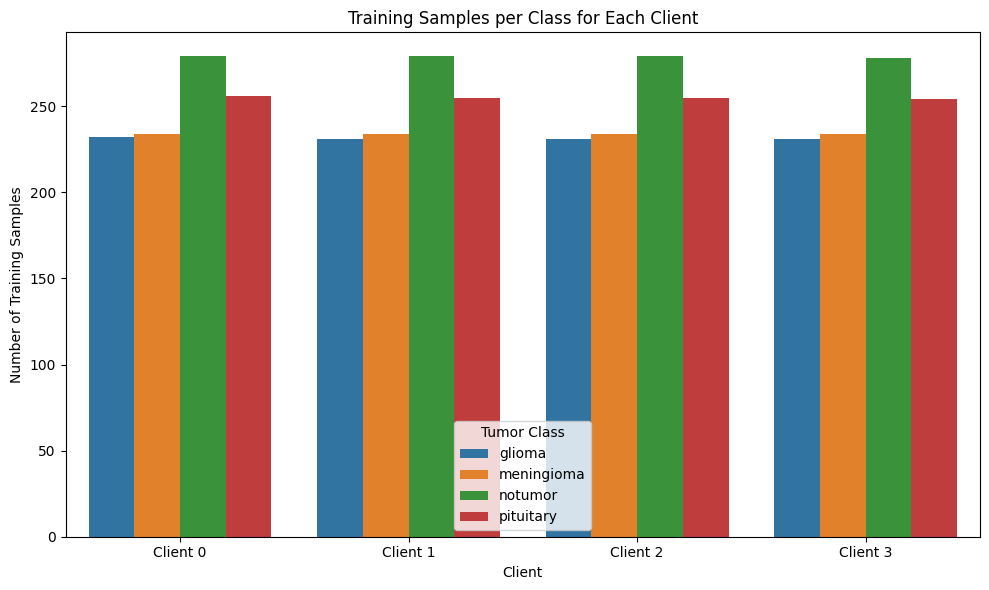

In [ ]:
# --- Visualization: Training Samples per Class per Client ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
data_plot = {'Client': [], 'Class': [], 'Count': []}

for cid, splits in ACTIVE_SPLITS.items():
    train_data = splits['train']
    label_counts = {lbl: 0 for lbl in CLASS_NAMES}
    for _, label in train_data:
        label_name = CLASS_NAMES[label] if isinstance(label, int) else label
        label_counts[label_name] += 1
    for lbl in CLASS_NAMES:
        data_plot['Client'].append(f'Client {cid}')
        data_plot['Class'].append(lbl)
        data_plot['Count'].append(label_counts[lbl])

df_plot = pd.DataFrame(data_plot)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Client', y='Count', hue='Class', data=df_plot)
plt.title('Training Samples per Class for Each Client')
plt.xlabel('Client')
plt.ylabel('Number of Training Samples')
plt.legend(title='Tumor Class')
plt.tight_layout()
plt.show()

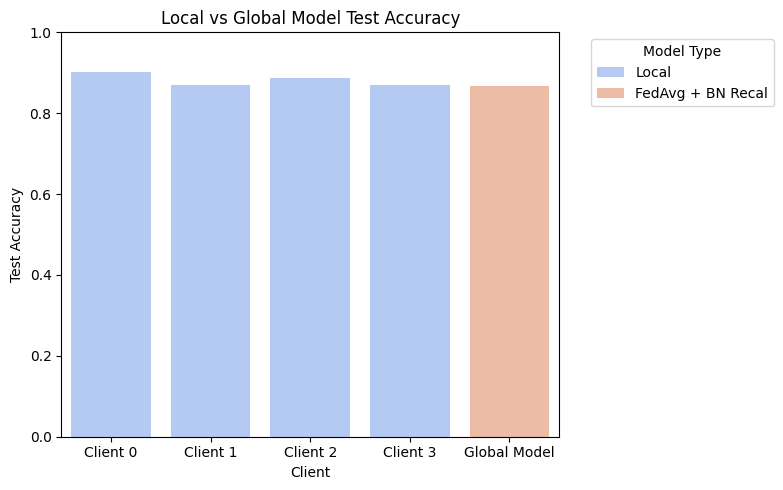

In [17]:
# Visualization: Local vs. Global Test Accuracies ---

# Collect results
results_summary = []

# Local clients
for cid, res in local_results.items():
    results_summary.append({
        'Client': f'Client {cid}',
        'Type': 'Local',
        'Accuracy': res['test_acc']
    })

# Global (after BN recalibration)
results_summary.append({
    'Client': 'Global Model',
    'Type': 'FedAvg + BN Recal',
    'Accuracy': g_acc_fix  # from your last BN recal output
})

df_acc = pd.DataFrame(results_summary)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Client', y='Accuracy', hue='Type', data=df_acc, palette='coolwarm')
plt.title('Local vs Global Model Test Accuracy')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

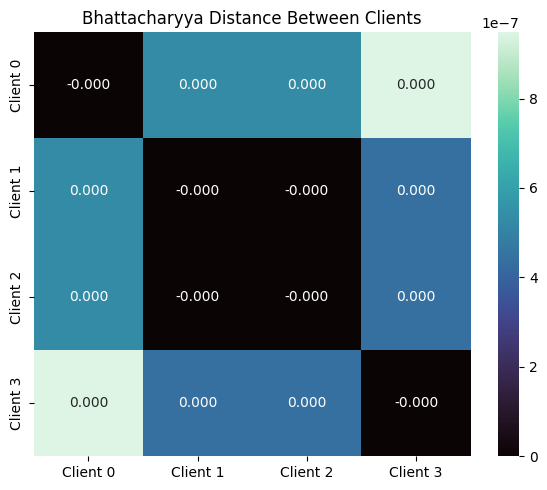

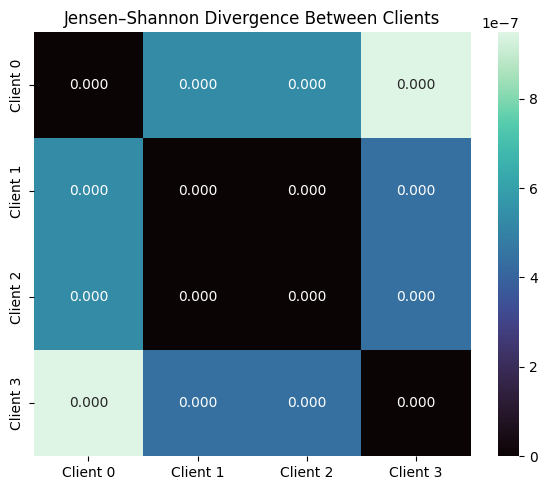

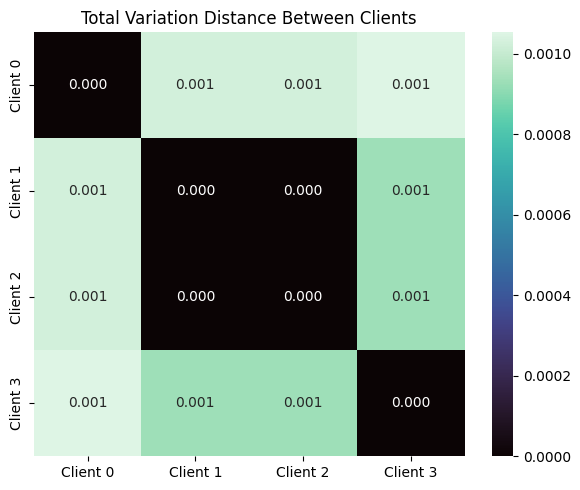

In [16]:
# --- Visualization: Client Distribution Divergence Heatmaps ---

import numpy as np
from scipy.stats import entropy

def get_class_distribution(client_data, class_labels):
    counts = {label: 0 for label in class_labels}
    for _, label in client_data:
        label_name = CLASS_NAMES[label] if isinstance(label, int) else label
        counts[label_name] += 1
    total = sum(counts.values())
    return np.array([counts[label] / total if total > 0 else 0 for label in class_labels])

def bhattacharyya_distance(p, q, eps=1e-10):
    p = p + eps; q = q + eps
    bc = np.sum(np.sqrt(p * q))
    return -np.log(bc)

def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def jensen_shannon_divergence(p, q, eps=1e-10):
    p = p + eps; q = q + eps
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def compute_divergence_matrix(clients_splits, class_labels):
    dists = []
    for cid, splits in clients_splits.items():
        dists.append(get_class_distribution(splits['train'], class_labels))
    n = len(dists)
    bhatt = np.zeros((n, n))
    jsd = np.zeros((n, n))
    tvd = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            bhatt[i, j] = bhattacharyya_distance(dists[i], dists[j])
            jsd[i, j] = jensen_shannon_divergence(dists[i], dists[j])
            tvd[i, j] = total_variation_distance(dists[i], dists[j])
    return bhatt, jsd, tvd

bhatt, jsd, tvd = compute_divergence_matrix(ACTIVE_SPLITS, CLASS_NAMES)
client_labels = [f"Client {i}" for i in range(len(ACTIVE_SPLITS))]

def plot_heatmap(matrix, title):
    df = pd.DataFrame(matrix, index=client_labels, columns=client_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(df, annot=True, fmt=".3f", cmap='mako')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(bhatt, 'Bhattacharyya Distance Between Clients')
plot_heatmap(jsd, 'Jensen–Shannon Divergence Between Clients')
plot_heatmap(tvd, 'Total Variation Distance Between Clients')

### Personalization after the Global Model

In [18]:
# --- Personalization Phase (Client-specific fine-tuning) ---

import copy
from torch import optim
from tqdm import tqdm

def fine_tune_local_model(global_model, client_splits, epochs=2, lr=1e-4):
    """
    Fine-tune the global model on a client's local training data.
    Returns the personalized model and its test accuracy.
    """
    model = copy.deepcopy(global_model)
    model.to(device)
    model.train()

    # Use smaller LR and fewer epochs (since we’re just adapting)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Build loaders
    dl_train, dl_val, dl_test = make_client_loaders(client_splits, batch_size=32)

    # Fine-tune
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in tqdm(dl_train, desc=f"Fine-tuning Epoch {epoch+1}/{epochs}", leave=False):
            if batch is None:
                continue
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"  → Client fine-tune epoch {epoch+1}: Loss = {running_loss/len(dl_train):.4f}")

    # Evaluate before and after fine-tuning
    model.eval()
    loss, acc = evaluate_model(model, dl_test, criterion)
    return model, acc


# Run personalization for all clients
personalized_results = {}
criterion = nn.CrossEntropyLoss()

print("=== PERSONALIZATION PHASE ===")
for cid, splits in ACTIVE_SPLITS.items():
    print(f"\n[Client {cid}]")
    personalized_model, acc_personalized = fine_tune_local_model(global_model, splits, epochs=2, lr=1e-4)

    # Compare with the global model (before personalization)
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    _, acc_global_before = evaluate_model(global_model, dl_test, criterion)

    personalized_results[cid] = {
        'before': acc_global_before,
        'after': acc_personalized
    }
    print(f"[Client {cid}] Before personalization: {acc_global_before:.4f} | After: {acc_personalized:.4f}")

=== PERSONALIZATION PHASE ===

[Client 0]


  → Client fine-tune epoch 1: Loss = 0.2462


  → Client fine-tune epoch 2: Loss = 0.1424
[Client 0] Before personalization: 0.9231 | After: 0.9545

[Client 1]


  → Client fine-tune epoch 1: Loss = 0.2271


  → Client fine-tune epoch 2: Loss = 0.1201
[Client 1] Before personalization: 0.9231 | After: 0.9406

[Client 2]


  → Client fine-tune epoch 1: Loss = 0.2375


  → Client fine-tune epoch 2: Loss = 0.1123
[Client 2] Before personalization: 0.9196 | After: 0.9720

[Client 3]


  → Client fine-tune epoch 1: Loss = 0.2301


  → Client fine-tune epoch 2: Loss = 0.1135
[Client 3] Before personalization: 0.9301 | After: 0.9510


## ## Training, Validation and Testing with Non-IID split (Non-Identical Distribution)

In [34]:
# Use the Non-IID client splits from the code earlier
ACTIVE_SPLITS = clients_noniid_splits  # Changed to Non-IDD split

from collections import Counter

# (Optional) quick sanity print of counts (no visualization)
print("=== Non-IID training distribution (counts) ===")
for cid, s in ACTIVE_SPLITS.items():
    c = Counter([CLASS_NAMES[y] for _, y in s['train']])
    print(f"Client {cid}: {len(s['train'])} train | per-class: {dict(c)}")

=== Non-IID training distribution (counts) ===
Client 0: 1973 train | per-class: {'pituitary': 760, 'meningioma': 509, 'glioma': 465, 'notumor': 239}
Client 1: 388 train | per-class: {'pituitary': 14, 'notumor': 303, 'glioma': 25, 'meningioma': 46}
Client 2: 647 train | per-class: {'pituitary': 231, 'meningioma': 163, 'glioma': 252, 'notumor': 1}
Client 3: 987 train | per-class: {'notumor': 573, 'meningioma': 220, 'glioma': 182, 'pituitary': 12}


In [36]:
# --- Train local models per client on Non-IID splits ---

local_results_noniid = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=2,               # adjust for speed/quality (e.g., 2 for quick test)
        batch_size=32,
        lr=1e-3,
        pretrained=True,
        freeze_backbone=False,  # set True for faster runs
        patience=2
    )
    local_results_noniid[cid] = res

print("\n=== Non-IID Local Test Accuracies ===")
for cid, r in local_results_noniid.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")

[Client 0] Epoch 01 | Train L:0.5343 A:0.8074 | Val L:0.5534 A:0.8511 | 138.8s
[Client 0] Epoch 02 | Train L:0.2727 A:0.9138 | Val L:0.9463 A:0.6809 | 106.7s
[Client 0] Test  L:0.5837 A:0.8670
[Client 1] Epoch 01 | Train L:0.5889 A:0.8119 | Val L:0.3827 A:0.9464 | 29.4s
[Client 1] Epoch 02 | Train L:0.3026 A:0.8969 | Val L:5.3231 A:0.4464 | 21.5s
[Client 1] Test  L:0.2672 A:0.9196
[Client 2] Epoch 01 | Train L:0.6478 A:0.7651 | Val L:1.2363 A:0.7849 | 49.4s
[Client 2] Epoch 02 | Train L:0.3452 A:0.8547 | Val L:1.1871 A:0.6989 | 37.0s
[Client 2] Test  L:1.9960 A:0.6828
[Client 3] Epoch 01 | Train L:0.5423 A:0.8075 | Val L:1.0133 A:0.8511 | 78.6s
[Client 3] Epoch 02 | Train L:0.2766 A:0.8916 | Val L:0.3412 A:0.8865 | 64.5s
[Client 3] Test  L:0.2561 A:0.9011

=== Non-IID Local Test Accuracies ===
Client 0: Val* 0.8511 | Test 0.8670 | n_train=1973
Client 1: Val* 0.9464 | Test 0.9196 | n_train=388
Client 2: Val* 0.7849 | Test 0.6828 | n_train=647
Client 3: Val* 0.8865 | Test 0.9011 | n_trai

In [ ]:
# --- Aggregate (BN-safe FedAvg), recalibrate BN, and evaluate ---

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Build test loader once (global Testing set)
def collect_test_pairs(test_dir: Path):
    pairs = []
    for cls in CLASS_NAMES:
        cls_dir = test_dir / cls
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                pairs.append((p, LABEL_MAP[cls]))
    return pairs

test_pairs = collect_test_pairs(TEST_DIR)
test_ds = BrainTumorDataset(test_pairs, transform=eval_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                         persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)

# BN-safe FedAvg (don’t average BN buffers; copy from largest client)
def fedavg_params_bnfix(global_model, client_state_and_sizes):
    gdict = global_model.state_dict()
    largest_idx = max(range(len(client_state_and_sizes)), key=lambda i: client_state_and_sizes[i][1])
    ref_state, _ = client_state_and_sizes[largest_idx]
    with torch.no_grad():
        # copy BN buffers from reference
        for k in gdict.keys():
            if ("running_mean" in k) or ("running_var" in k) or ("num_batches_tracked" in k):
                gdict[k].copy_(ref_state[k])
        # weighted average parameters
        total = sum(n for _, n in client_state_and_sizes)
        for k in gdict.keys():
            if ("running_mean" in k) or ("running_var" in k) or ("num_batches_tracked" in k):
                continue
            acc = torch.zeros_like(gdict[k])
            for state, n in client_state_and_sizes:
                acc.add_(state[k].to(acc.dtype), alpha=float(n))
            gdict[k].copy_(acc / max(total, 1))
    global_model.load_state_dict(gdict)
    return global_model

# BN recalibration (forward-only on mixed calibration set)
def make_calibration_loader(clients_splits, per_client=200, batch_size=64):
    cal_pairs = []
    for cid, splits in clients_splits.items():
        cal_pairs.extend(splits['train'][:min(per_client, len(splits['train']))])
    cal_ds = BrainTumorDataset(cal_pairs, transform=eval_tfms)
    return DataLoader(cal_ds, batch_size=batch_size, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)

@torch.no_grad()
def bn_recalibrate(model, cal_loader, max_batches=50):
    was_training = model.training
    model.train()
    seen = 0
    for batch in cal_loader:
        if batch is None: continue
        x, _ = batch
        _ = model(x.to(device))  # updates BN running stats
        seen += 1
        if seen >= max_batches: break
    model.train(was_training)

# Build & aggregate
criterion = nn.CrossEntropyLoss()
global_model_noniid = build_global_model(pretrained=True)  # same policy as locals

client_state_and_sizes = [(res["best_state"], res["train_samples"])
                          for cid, res in local_results_noniid.items()]
global_model_noniid = fedavg_params_bnfix(global_model_noniid, client_state_and_sizes)

# Recalibrate BN on mixed Non-IID data
cal_loader = make_calibration_loader(ACTIVE_SPLITS, per_client=200, batch_size=64)
bn_recalibrate(global_model_noniid, cal_loader, max_batches=50)

# Evaluate global (Testing) + per-client tests
g_loss, g_acc = evaluate_model(global_model_noniid, test_loader, criterion)
print(f"\n[Non-IID Global FedAvg (BN-safe) + BN Recal]  Test Loss: {g_loss:.4f} | Test Acc: {g_acc:.4f}")

for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss, acc = evaluate_model(global_model_noniid, dl_test, criterion)
    print(f"[Global on Client {cid} test] Acc {acc:.4f}")



[Non-IID Global FedAvg (BN-safe) + BN Recal]  Test Loss: 0.7303 | Test Acc: 0.8261
[Global on Client 0 test] Acc 0.8475
[Global on Client 1 test] Acc 0.9286
[Global on Client 2 test] Acc 0.7796
[Global on Client 3 test] Acc 0.8940
Saved global_fedavg_bnfix_noniid.pth


### Vistualization of results and testing (Non-IID Split)

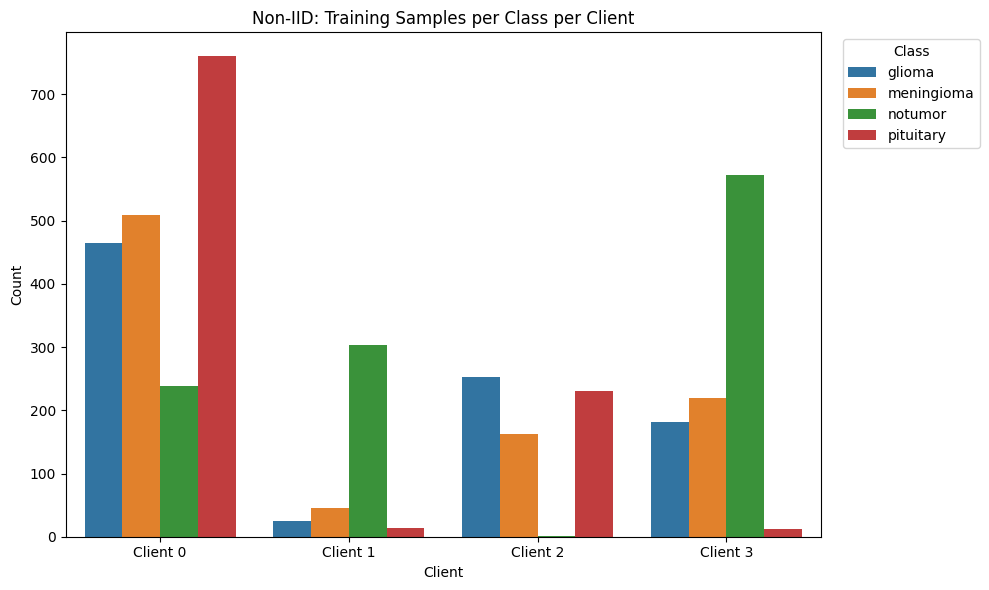

In [38]:
# --- Non-IID — training samples per class per client ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

data_plot = {'Client': [], 'Class': [], 'Count': []}
for cid, splits in ACTIVE_SPLITS.items():
    counts = Counter(CLASS_NAMES[y] for _, y in splits['train'])
    for cls in CLASS_NAMES:
        data_plot['Client'].append(f'Client {cid}')
        data_plot['Class'].append(cls)
        data_plot['Count'].append(counts.get(cls, 0))

df_plot = pd.DataFrame(data_plot)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Client', y='Count', hue='Class', data=df_plot)
ax.set_title('Non-IID: Training Samples per Class per Client')
ax.set_xlabel('Client'); ax.set_ylabel('Count')
ax.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

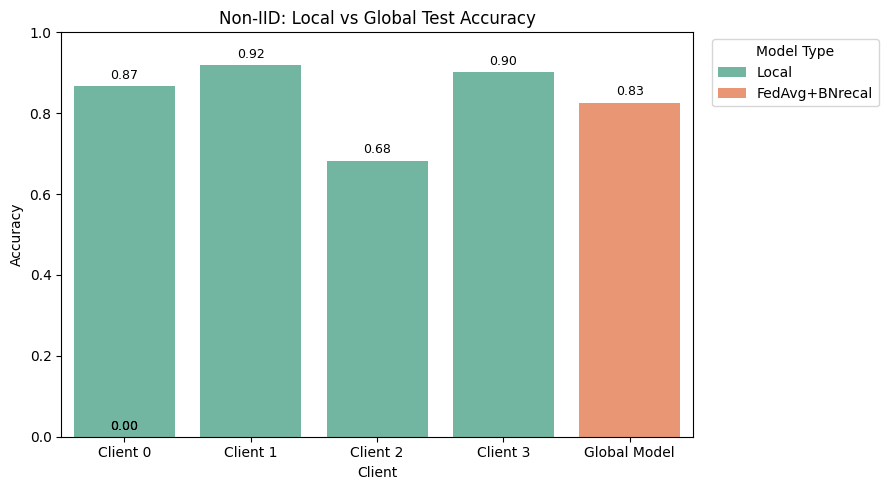

In [39]:
# --- Non-IID — Local vs Global accuracies ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_acc = pd.DataFrame(
    [{'Client': f'Client {cid}', 'Type': 'Local', 'Accuracy': r['test_acc']}
     for cid, r in local_results_noniid.items()] +
    [{'Client': 'Global Model', 'Type': 'FedAvg+BNrecal', 'Accuracy': g_acc}]
)

plt.figure(figsize=(9, 5))
ax = sns.barplot(x='Client', y='Accuracy', hue='Type', data=df_acc, palette='Set2')
ax.set_title('Non-IID: Local vs Global Test Accuracy')
ax.set_ylim(0, 1); ax.set_ylabel('Accuracy')
ax.legend(title='Model Type', bbox_to_anchor=(1.02, 1), loc='upper left')

# annotate bars with values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.tight_layout()
plt.show()

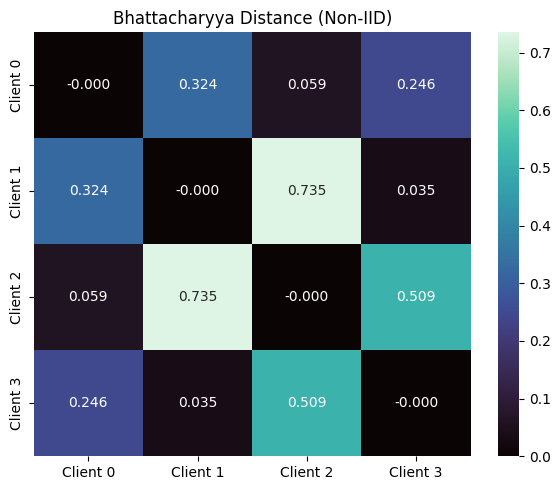

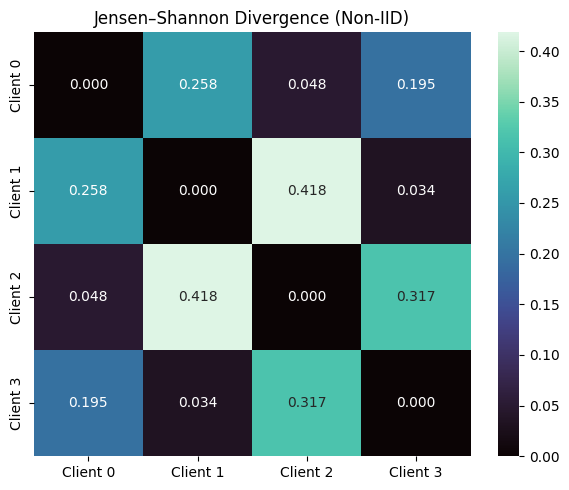

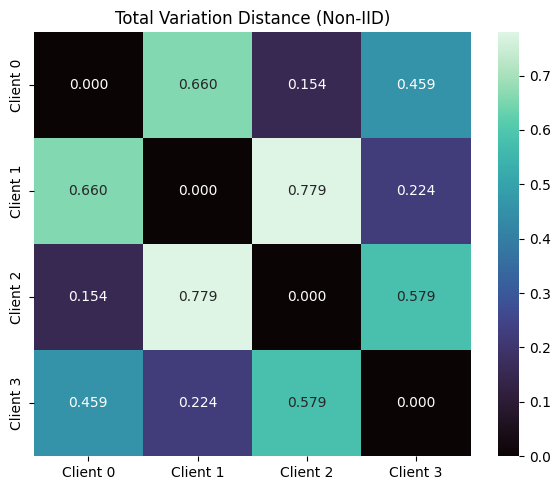

In [40]:
# --- Non-IID — divergence between client class distributions ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def dist_vec(pairs):
    counts = {cls: 0 for cls in CLASS_NAMES}
    for _, y in pairs:
        counts[CLASS_NAMES[y]] += 1
    total = sum(counts.values())
    return np.array([counts[c]/total if total else 0 for c in CLASS_NAMES], dtype=float)

def bhattacharyya_distance(p, q, eps=1e-12):
    p, q = p + eps, q + eps
    return -np.log(np.sum(np.sqrt(p*q)))

def total_variation_distance(p, q):
    return 0.5*np.sum(np.abs(p-q))

def jensen_shannon_divergence(p, q, eps=1e-12):
    p, q = p + eps, q + eps
    m = 0.5*(p+q)
    return 0.5*entropy(p, m) + 0.5*entropy(q, m)

vecs = [dist_vec(s['train']) for _, s in ACTIVE_SPLITS.items()]
n = len(vecs)
bh = np.zeros((n, n)); jsd = np.zeros((n, n)); tvd = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        bh[i,j]  = bhattacharyya_distance(vecs[i], vecs[j])
        jsd[i,j] = jensen_shannon_divergence(vecs[i], vecs[j])
        tvd[i,j] = total_variation_distance(vecs[i], vecs[j])

labels = [f"Client {i}" for i in range(n)]

def plot_hm(M, title):
    df = pd.DataFrame(M, index=labels, columns=labels)
    plt.figure(figsize=(6,5))
    ax = sns.heatmap(df, annot=True, fmt=".3f", cmap='mako')
    ax.set_title(title)
    plt.tight_layout(); plt.show()

plot_hm(bh,  'Bhattacharyya Distance (Non-IID)')
plot_hm(jsd, 'Jensen–Shannon Divergence (Non-IID)')
plot_hm(tvd, 'Total Variation Distance (Non-IID)')

<Figure size 600x600 with 0 Axes>

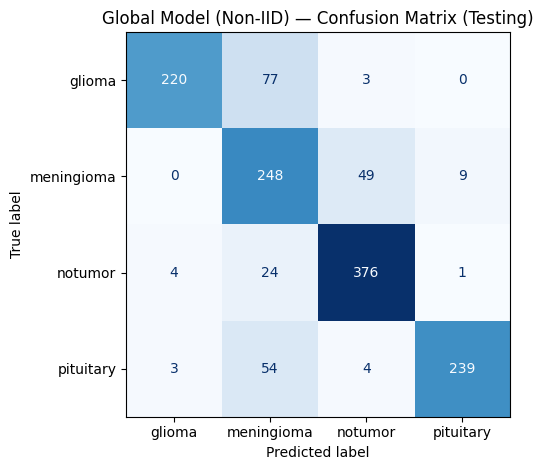

In [41]:
# --- Non-IID — Global model confusion matrix on Testing ---

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

y_true, y_pred = [], []
global_model_noniid.eval()
with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue
        x, y = batch
        logits = global_model_noniid(x.to(device))
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
plt.figure(figsize=(6,6))
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title('Global Model (Non-IID) — Confusion Matrix (Testing)')
plt.tight_layout()
plt.show()